## Feature Selection Comparison:
1. Load UCI Credit dataset.
2. Create noisy data with make classification.
3. Try different Feature selection algorithms.
4. Compare results.
5. Conclusion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import shap
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from stability_selection import StabilitySelection, plot_stability_path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import cross_val_score,cross_validate
from xgboost import XGBClassifier

### 1. Read UCI Credit Card and add noise.

In [2]:
data = pd.read_csv('data/train_fin_cols.csv')

y_org = data['loan_default']
X_org = data.drop(['loan_default'],axis=1)

print("Loaded train data with shape {}".format(X_org.shape))

categorical_columns_to_drop = ['uniqueid','branch_id','supplier_id','manufacturer_id','current_pincode_id',
                               'state_id','employee_code_id','perform_cns_score_description','employment_type','state_hrg','emp_hrg',
                              'branch_hrg','pincode_hrg','supplier_hrg','manf_hrg']
categorical_columns = ['employment_type','perform_cns_score_description']

X_lnt = X_org.drop(categorical_columns_to_drop,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_lnt, y_org,
                                                    test_size=0.3,random_state=345)
X_lnt.head()

Loaded train data with shape (233154, 58)


,disbursed_amount,asset_cost,ltv,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,...,score_hrg,scored,amt_rejected,loan_to_pbal,sec_loan_to_pbal,pri_avg_installments,pri_avg_active_installments,sec_avg_installments,sec_avg_active_installments,tenure_primary
0,50578.0,58400.0,89.55,1,1,0,0,0,0,0,...,0,0,0.133938,50578.00000,50578.0,0.0,0.0,0.0,0.0,0.000000
1,47145.0,65550.0,73.23,1,1,0,0,0,0,598,...,1,1,0.280778,1.70809,47145.0,50200.0,50200.0,0.0,0.0,2.100067
2,53278.0,61360.0,89.63,1,1,0,0,0,0,0,...,0,0,0.131714,53278.00000,53278.0,0.0,0.0,0.0,0.0,0.000000
3,57513.0,66113.0,88.48,1,1,0,0,0,0,305,...,1,1,0.130080,57513.00000,57513.0,0.0,0.0,0.0,0.0,0.000000
4,52378.0,60300.0,88.39,1,1,0,0,0,0,0,...,0,0,0.131376,52378.00000,52378.0,0.0,0.0,0.0,0.0,0.000000


### 2.Stability Selection:

Fitting estimator for lambda = 4.00000 (1 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.6s finished


Fitting estimator for lambda = 5.00000 (2 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   17.6s finished


Fitting estimator for lambda = 6.00000 (3 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   22.8s finished


Fitting estimator for lambda = 7.00000 (4 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   25.9s finished


Fitting estimator for lambda = 8.00000 (5 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   29.0s finished


Fitting estimator for lambda = 9.00000 (6 / 6) on 100 bootstrap samples


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   31.6s finished


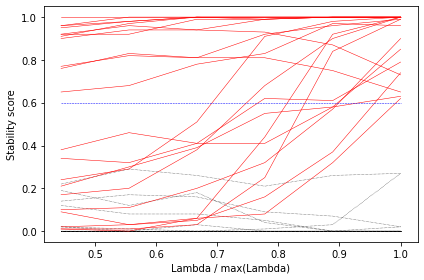

In [3]:
base_estimator = Pipeline([
    ('model', RandomForestClassifier(max_depth=4,n_estimators=10,n_jobs=4))])

selector = StabilitySelection(base_estimator=base_estimator,
                              lambda_name='model__max_depth',
                              n_bootstrap_iterations=100,
                              n_jobs=4,
                              lambda_grid=np.arange(4,10,step=1),
                              verbose=1)
selector.fit(X_train,y_train)

fig, ax = plot_stability_path(selector)
fig.show()

In [13]:
# Print the names of the most important features
selected_variables = selector.get_support(indices=True)
selected_scores = selector.stability_scores_.max(axis=1)
ss_flist = []
for feature_list_index in selector.get_support(indices=True):
    print(f'Variable Name : {X_lnt.columns[feature_list_index]} \t Stability Score :{selected_scores[feature_list_index]}')
    ss_flist.append(X_lnt.columns[feature_list_index])

n_feats = len(ss_flist)
print(f'No.of features selected {n_feats} \n')

Variable Name : disbursed_amount 	 Stability Score :1.0
Variable Name : asset_cost 	 Stability Score :1.0
Variable Name : ltv 	 Stability Score :1.0
Variable Name : perform_cns_score 	 Stability Score :1.0
Variable Name : pri_overdue_accts 	 Stability Score :0.82
Variable Name : pri_current_balance 	 Stability Score :0.79
Variable Name : pri_sanctioned_amount 	 Stability Score :0.99
Variable Name : pri_disbursed_amount 	 Stability Score :0.97
Variable Name : no_of_inquiries 	 Stability Score :0.63
Variable Name : age_when_disbursal 	 Stability Score :0.99
Variable Name : avg_acct_age_m 	 Stability Score :0.62
Variable Name : credit_hist_len_m 	 Stability Score :1.0
Variable Name : calc_ltv 	 Stability Score :1.0
Variable Name : ltv_delta 	 Stability Score :1.0
Variable Name : score_hrg 	 Stability Score :0.94
Variable Name : amt_rejected 	 Stability Score :1.0
Variable Name : loan_to_pbal 	 Stability Score :1.0
Variable Name : sec_loan_to_pbal 	 Stability Score :1.0
Variable Name : pri

### 3.SHAP Feature Importances

In [14]:
# Build the model with the random forest regression algorithm:
model = RandomForestClassifier(max_depth=4, random_state=456, n_estimators=20)
model.fit(X_train,y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train,y_train,check_additivity=False)

shap_vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_lnt.columns, sum(shap_vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
shap_flist = list(feature_importance.col_name[0:n_feats])
print(shap_flist)

['perform_cns_score', 'ltv', 'disbursed_amount', 'calc_ltv', 'amt_rejected', 'sec_loan_to_pbal', 'score_hrg', 'loan_to_pbal', 'pri_sanctioned_amount', 'pri_overdue_accts', 'pri_disbursed_amount', 'pri_no_of_accts', 'pri_avg_active_installments', 'pri_current_balance', 'no_of_inquiries', 'aadhar_flag', 'delinquent_accts_in_last_six_months', 'tenure_primary', 'avg_acct_age_m', 'voterid_flag', 'asset_cost']


### 4.MLXtend SFS

In [15]:
sfs1 = SFS(model, 
           k_features=(n_feats-5,n_feats), 
           forward=True, 
           floating=True, 
           verbose=1,
           scoring='roc_auc',
           n_jobs=6,
           cv=3)

sfs1 = sfs1.fit(X_train, y_train)
sfs1_flist=list(sfs1.k_feature_names_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  43 out of  43 | elapsed:   16.6s finished
Features: 1/21[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  42 | elapsed:   26.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    3.0s finished
Features: 2/21[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:   24.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    2.6s finished
Features: 3/21[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   35.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_j

### 5.Combine selected features.

In [18]:
print(sfs1_flist)
total_fs_list=list(set(sfs1_flist+ss_flist+shap_flist))

fs_method_list = [("SS",ss_flist),
                  ("SFS",sfs1_flist),
                  ("SHAP",shap_flist),
                  ("FSP",total_fs_list),
                  ("All Columns",list(X_lnt.columns))]

result_df = pd.DataFrame()

# xgb_params={'n_estimators': 284, 'max_depth': 18, 
#             'min_child_weight': 6, 'scale_pos_weight': 66, 
#             'subsample': 0.8, 'colsample_bytree': 0.8}

for feature_list in fs_method_list:
    
    print(f'Features selected with {feature_list[0]} : {feature_list[1]} \n')
    X_fs = X_lnt[feature_list[1]]
    clf = XGBClassifier()
    scores = cross_validate(clf,X_fs,y_org,cv=5,scoring='roc_auc',return_train_score=True)
    
    result_df[f'{feature_list[0]}_mean_train_score']=scores['train_score']
    result_df[f'{feature_list[0]}_mean_test_score']=scores['test_score']
    result_df[f'{feature_list[0]}_mean_overfit']=(scores['train_score']-scores['test_score'])


['asset_cost', 'ltv', 'aadhar_flag', 'voterid_flag', 'perform_cns_score', 'pri_no_of_accts', 'pri_active_accts', 'pri_overdue_accts', 'pri_sanctioned_amount', 'pri_disbursed_amount', 'primary_instal_amt', 'delinquent_accts_in_last_six_months', 'no_of_inquiries', 'age_when_disbursal', 'avg_acct_age_m', 'credit_hist_len_m', 'scored', 'sec_loan_to_pbal', 'sec_avg_active_installments']
Features selected with SS : ['disbursed_amount', 'asset_cost', 'ltv', 'perform_cns_score', 'pri_overdue_accts', 'pri_current_balance', 'pri_sanctioned_amount', 'pri_disbursed_amount', 'no_of_inquiries', 'age_when_disbursal', 'avg_acct_age_m', 'credit_hist_len_m', 'calc_ltv', 'ltv_delta', 'score_hrg', 'amt_rejected', 'loan_to_pbal', 'sec_loan_to_pbal', 'pri_avg_installments', 'pri_avg_active_installments', 'tenure_primary'] 

Features selected with SFS : ['asset_cost', 'ltv', 'aadhar_flag', 'voterid_flag', 'perform_cns_score', 'pri_no_of_accts', 'pri_active_accts', 'pri_overdue_accts', 'pri_sanctioned_amount'

### 6.Results

In [19]:
result_df

,SS_mean_train_score,SS_mean_test_score,SS_mean_overfit,SFS_mean_train_score,SFS_mean_test_score,SFS_mean_overfit,SHAP_mean_train_score,SHAP_mean_test_score,SHAP_mean_overfit,FSP_mean_train_score,FSP_mean_test_score,FSP_mean_overfit,All Columns_mean_train_score,All Columns_mean_test_score,All Columns_mean_overfit
0,0.721148,0.624808,0.096340,0.717414,0.627021,0.090393,0.715159,0.627693,0.087466,0.724752,0.627729,0.097024,0.721874,0.629432,0.092441
1,0.720661,0.631394,0.089267,0.715705,0.636295,0.079410,0.716595,0.633676,0.082920,0.726355,0.637669,0.088685,0.724037,0.639204,0.084834
2,0.720203,0.624689,0.095513,0.716490,0.631115,0.085375,0.713207,0.629375,0.083832,0.728082,0.628164,0.099918,0.726651,0.631233,0.095418
3,0.720544,0.628197,0.092347,0.717114,0.631096,0.086017,0.714697,0.627745,0.086951,0.722876,0.632172,0.090703,0.721378,0.633777,0.087601
4,0.718675,0.616675,0.102000,0.713098,0.622970,0.090128,0.712322,0.621395,0.090927,0.728381,0.621628,0.106754,0.724511,0.626335,0.098176


In [20]:
result_df.apply(lambda x :np.mean(x),axis=0)

SS_mean_train_score             0.720246
SS_mean_test_score              0.625153
SS_mean_overfit                 0.095093
SFS_mean_train_score            0.715964
SFS_mean_test_score             0.629699
SFS_mean_overfit                0.086265
SHAP_mean_train_score           0.714396
SHAP_mean_test_score            0.627977
SHAP_mean_overfit               0.086419
FSP_mean_train_score            0.726089
FSP_mean_test_score             0.629472
FSP_mean_overfit                0.096617
All Columns_mean_train_score    0.723690
All Columns_mean_test_score     0.631996
All Columns_mean_overfit        0.091694
dtype: float64

### Appendix
Optimisation using Optuna.

In [26]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import optuna
import functools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,accuracy_score,f1_score,roc_auc_score

In [27]:
def opt(X_train, y_train, X_test, y_test, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.01, 0.1, 0.01)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 100)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)

    xgboost_tuna = xgb.XGBClassifier(
        random_state=946, 
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        scale_pos_weight = scale_pos_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict_proba(X_test)[:,1]
    
    return (1.0 - (roc_auc_score(y_test,tuna_pred_test)))

def get_opt_parameters(X,y):
    """
    Takes X,y and returns best parameters.
    
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5,random_state=345)
    study = optuna.create_study()
    study.optimize(functools.partial(opt,X_train, y_train, X_test, y_test),n_trials=10)
    return study.best_params
    

In [29]:
fs_method_list = [("SS",ss_flist),
                  ("SFS",sfs1_flist),
                  ("SHAP",shap_flist),
                  ("FSP",total_fs_list)]

result_df = pd.DataFrame()

for feature_list in fs_method_list:
    
    print(f'Features selected with {feature_list[0]} : {feature_list[1]} \n')
    
    X_fs = X_lnt[feature_list[1]]
    optimised_param = get_opt_parameters(X_fs,y_org)
    
    clf = XGBClassifier(**optimised_param)
    
    scores = cross_validate(clf,X_fs,y,cv=3,scoring='roc_auc',return_train_score=True)
    
    result_df[f'{feature_list[0]}_mean_train_score']=scores['train_score']
    result_df[f'{feature_list[0]}_mean_test_score']=scores['test_score']
    result_df[f'{feature_list[0]}_mean_overfit']=(scores['train_score']-scores['test_score'])

In [ ]:
result_df.apply(lambda x :np.mean(x),axis=0)